# Python Machine Learning - Discriminant Analysis, Naive Bayes and NLP

<p><a name="sections"></a></p>


## Sections

- <a href="#discriminant">Discriminant Analysis</a><br>
    - <a href="#bayes">Bayes Theorem</a><br>
    - <a href="#theory">Discriminant Analysis: Basic Theories</a><br>
    - <a href="#bayes_classifier">Bayes Classifier</a><br>
- <a href="#models">Discriminant Analysis: Models</a><br>
    - <a href="#oneD">One Dimensional Cases</a><br>
    - <a href="#highD">Higher Dimensional Cases</a><br>
        - <a href="#highG">Higher Dimensional Gaussian Distribution</a><br>
        - <a href="#highM">Models is Higher Dimension</a><br>
- <a href="#discriminant-sklearn">Discriminant Analysis in Scikit-Learn</a><br>
    - <a href="#ex3">Exercise 1</a><br>
    - <a href="#ex4">Exercise 2</a><br>
- <a href="#nb">Naive Bayes</a><br>
    - <a href="#gnb">Gaussian Naive Bayes</a><br>
    - <a href="#gnb-sklearn">Gaussian Naive Bayes in Scikit Learn</a><br>
    - <a href="#mnb">Multinomial Naive Bayes</a><br>
    - <a href="#wmnb">Working Example of Multinomial Naive Bayes</a><br>
    - <a href="#mnb-sklearn">Multinomial Naive Bayes in Scikit Learn</a><br>
    - <a href="#bnb">Bernoulli Naive Bayes</a><br>
    - <a href="#bnb-sklearn">Bernoulli Naive Bayes in Scikit Learn</a><br>

<p><a name="discriminant"></a></p>
## Discriminant Analysis

**As a preparation, let us load some python modules and define some helper funtions**

In [1]:
import numpy as np
import pandas as pd
from PlottingFunction import multivariate_normal, multivariate_normal_plot, show_sample 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

**The Concept of Conditional Probability**

Let $Y$ be an event with probability $P(Y) > 0$, the conditional probability of observing $X$ given that $Y$ has occurred is defined as:

$$
P(X|Y) = \frac{P(X,Y)}{P(Y)}
$$

- $P(X,Y)$ refers to the joint probability of observing both the event $X$ and event $Y$. 
- $P(X|Y)$ is the probability of event $X$ after insuring event $Y$'s occurrence.

**Example**: Suppose that we are given a random number uniformly distributed across 0 to 1. How do we compute the probability of the number falling into the blue region (plotted in the output of the next code block)?

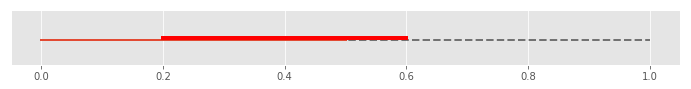

In [2]:
fig = plt.figure(figsize=(12, 1))
plt.plot([0, 1],[-0.01, -0.01], color='k', ls='--', linewidth=2, alpha=0.5)
plt.plot([0, 0.5],[-0.01, -0.01], linewidth=2, alpha=1)
plt.plot([0.2, 0.6],[0, 0], color='blue', linewidth=4)
plt.ylim(-0.1, 0.1)
plt.xticks()
plt.yticks([])
plt.show()

If $X$ and $Y$ are independent, $P(X, Y) = P(X)P(Y)$:

- Then the conditional probability is nothing but

$$P(X|Y) = \frac{P(X, Y)}{P(Y)} = \frac{P(X)P(Y)}{P(Y)}  = P(X)$$ 

- This implies the occurrence of $Y$ does not have any impact on the probability of the occurrence of $X$


**Conditional Probability Example**

Consider an experiment of picking balls of two colors, red and black, from two boxes labeled A and B.

- There are 10 black balls and 1 red ball in box A, and 1 black ball and 10 red balls in box B.
- We randomly choose a box (with equal chance) and then pick a ball from the chosen box.
- What is the probability that we draw a red ball?

<img src='./pic/balls_in_box.png'>

While choosing a box, we have:
- $P(A)=P(B)=0.5$.
- If we choose A, $P(red|A) = 1/11$. 
- if we choose B, $P(red|B) = 10/11$.

So the total probability to draw one red ball is:
$$
\begin{align}
P(red) &= P(red|A)\cdot P(A)+P(red|B)\cdot P(B)
\\
&= \frac{1}{11} \times 0.5 + \frac{10}{11} \times 0.5 
\\
&= \frac{1}{2}
\end{align}
$$

The 0.5 probability can be computed by ignoring the boxes and lump the balls together.

- There are 1+10 red balls and 10+1 blacks balls. So the chance to get a red ball is 11.0/22.0 = 0.5

- This works because the prior probabilities of choosing box A and B are the same

<p><a name="bayes"></a></p>
### Bayes Theorem

Bayes theorem is named after [Thomas Bayes](https://en.wikipedia.org/wiki/Thomas_Bayes).

It describes the probability of an event, based on some prior condition that might be related to the event. 

For simplicity we assume that the event $Y$ has a finite number of outcomes, parametrized by $l$.

Then Bayes theorem is stated mathematically as the following equation:

$$
\begin{align}
P(Y|X) &= \frac{P(X|Y)\cdot P(Y)}{P(X)}
\\
&= \frac{P(X|Y)\cdot P(Y)}{\sum_{l}P(X|Y=l)\cdot P(Y=l)}
\end{align}
$$

How does this relate to our classification problem?

Consider from the ball-picking example we realize that for a red ball,

- the probability that it's from Box A is $\frac{1}{11}$.
- the probability that it's from Box B is $\frac{10}{11}$.

Next time if we get a red ball, shouldn't we be more confident that the ball has been from box B?

<p><a name="theory"></a></p>
### Discriminant Analysis: Basic Theory

When we label the data set according to the classification outcome, we may hypothesize that each sub-data set is generated 
from certain type of probability distributions. 
Discriminant analysis is a statistical technique which classifies by determining the probability distributions of all classes based on the data.

- The type of probability distribution is hypothesized. But the specific distribution is pinned down by data fitting

**Motivation**

To be more precise, let's consider a simulated example, performing binary classification based on a numerical feature.

In [3]:
#### Creating the Data
from scipy import stats

end = 30
len_0 = 70
len_1 = 70
color_0 = 'r'
color_1 = 'g'

np.random.seed(108)
x_0 = stats.gamma(9, 0.5).rvs(len_0)
x_1 = stats.norm(15, 6).rvs(len_1)
y   = np.array([color_0]*len_0 + [color_1]*len_1)  #  first len_0 of class r, the next len_1 of class g

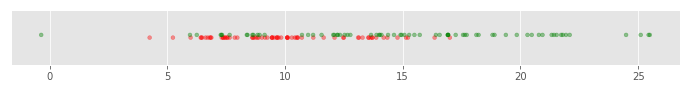

In [4]:
#### Visualize the Data

plt.figure(figsize=(12, 1))
plt.ylim(-0.1, .1)
plt.yticks([])
scatter_kwargs = dict(color=y, s=15, alpha=0.4)
plt.scatter(x=np.concatenate([x_0, x_1]), y=[0]*len_0 + [0.01]*len_1, **scatter_kwargs)
plt.show()

If we found a new observation, which class do you think it belongs to?

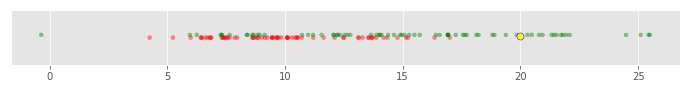

In [5]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                plt.figure(figsize=(12, 1))
plt.ylim(-0.1, .1)
plt.yticks([])
plt.scatter(x=np.concatenate([x_0, x_1]), y=[0]*len_0 + [0.01]*len_1, **scatter_kwargs)
plt.scatter(20, 0.005, c='yellow', s=50, edgecolors='b')
plt.show()

What about the next one?

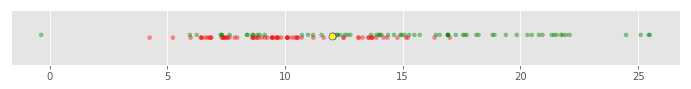

In [6]:
plt.figure(figsize=(12, 1))
plt.ylim(-0.1, .1)
plt.yticks([])
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.01]*len_1, **scatter_kwargs)
plt.scatter(12, 0.005, c='yellow', s=50, edgecolors='b')
plt.show()

What makes us feel differently?

- If there is some other information tacitly guided us to the conclusion, can we somehow name it? Or visualize it?

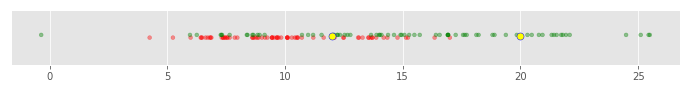

In [7]:
plt.figure(figsize=(12, 1))
plt.ylim(-0.1, .1)
plt.yticks([])
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.01]*len_1, **scatter_kwargs)
yellow_kwargs = dict(c='yellow', s=50, edgecolors='b')
plt.scatter(20, 0.005, **yellow_kwargs)
plt.scatter(12, 0.005, **yellow_kwargs)
plt.show()

How about **density plot** for each class?  The data is generated from two known probability distributions. So we can
make the exact density plots.

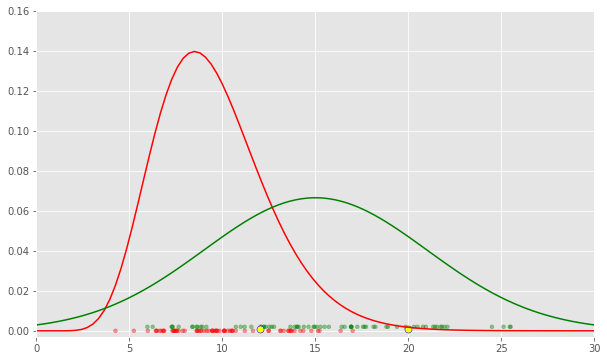

In [8]:
pdf_0 = stats.gamma(9, 0.5).pdf
pdf_1 = stats.norm(15, 6).pdf

lin_sp = np.linspace(start=0, stop=end, num=100)
plt.figure(figsize=(10, 6))
plt.plot(lin_sp, pdf_0(lin_sp), color=color_0)
plt.plot(lin_sp, pdf_1(lin_sp), color=color_1)
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.002]*len_1, **scatter_kwargs)
plt.ylim(-0.003, 0.16)
plt.xlim(0, 30)
yellow_kwargs = dict(c='yellow', s=50, edgecolors='b')
plt.scatter(20, 0.001, **yellow_kwargs)
plt.scatter(12, 0.001, **yellow_kwargs)
plt.show()

What's the difference between the two observations?

- when x = 20, the red and green classes have dramatically different probability densities; but for x = 12, it is not the case!

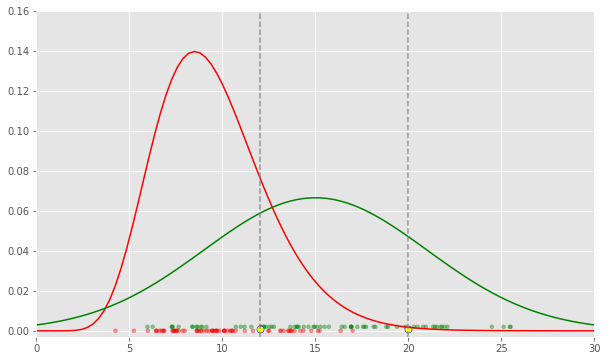

In [9]:
lin_sp = np.linspace(start=0, stop=end, num=100)
plt.figure(figsize=(10, 6))
plt.plot(lin_sp, pdf_0(lin_sp), color=color_0)
plt.plot(lin_sp, pdf_1(lin_sp), color=color_1)
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.002]*len_1, **scatter_kwargs)
plt.ylim(-0.003, 0.16)
plt.xlim(0, 30)
yellow_kwargs = dict(c='yellow', s=50, edgecolors='b')
plt.scatter(20, 0.001, **yellow_kwargs)
plt.scatter(12, 0.001, **yellow_kwargs)
line_kwargs = dict(ls='--', color= 'grey', alpha=0.8)
plt.axvline(x=20, **line_kwargs)
plt.axvline(x=12, **line_kwargs)
plt.show()

Note that to perform classification, we need to compute

$$
\text{ }\\
P(Y=k \ | \ X =x ) \text{ for each class k}
$$

But we just found that

$$
\text{ }\\
p(X=x \ | \ Y=k) \text{ for each class k}
$$

is helpful! 

**How do we relate the two kinds of conditional probability?**

**Discriminant Analysis and Bayes Theorem**

Bayes theorem comes into play because we want to relate the two conditional probabilities above.

$$
P(Y=k \ | \ X=x) = \frac{p(X=x \ | \ Y=k) P(Y=k)}{\sum_{l}p(X=x \ | \ Y=l) P(Y=l)}
$$

**Questions**:

- How do we estimate $P(Y = k) \text{ (this is called the } \textbf{prior probability } \text{for class k)} \text{ ?}$
- How do we estimate $p(X=x \ | \ Y=k)\text{ ?}$

**Answers**

- The natural candidate for estimating $P(Y=k) \text{ is simply } \frac{n_k}{n}$, the fraction of observations, where
 - $n_k$ is the number of observations in class k.
 - $n$ is the total number of the observations.
- Modeling $p(X=x \ | \ Y=k)$ is nontrivial! Different models (hypotheses on the probability distributions) result in different types of classifiers as we will see.

<p><a name="bayes_classifier"></a></p>
### Bayes Classifier

Once we can predict the probability of an observation belonging to any class, we can then classify the observation to the class with the highest estimated probability.

- This is known as **Bayes classifier**. It minimises the probability of misclassification.
- The boundary of classification (decision boundary) is simply the location where the probabilities of different classes become the same.

**Caution**

Let us ignore temporarily the fact that the class prior probabilities can be different. Thus
the plot below is not necessarily the right way to find the decision boundary

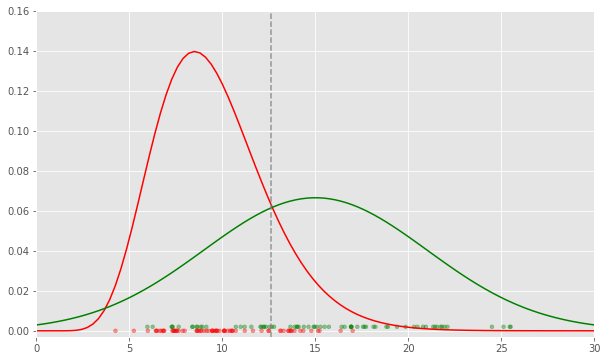

In [10]:
lin_sp = np.linspace(start=0, stop=end, num=100)
plt.figure(figsize=(10, 6))
plt.plot(lin_sp, pdf_0(lin_sp), color=color_0)
plt.plot(lin_sp, pdf_1(lin_sp), color=color_1)
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.002]*len_1, **scatter_kwargs)
plt.ylim(-0.003, 0.16)
plt.xlim(0, 30)
plt.axvline(x=12.6, ls='--', color= 'grey', alpha=0.8)
plt.show()

**Observation** The prior probabilities play an important role in discriminant analysis, but we did **NOT** consider them in our primitive approach above.

- To emphasize the effect of the density within each class, we intentionally created two classes with the same size. When the sizes are different, missing the prior probability would cause a big trouble.

Below is an extreme case:

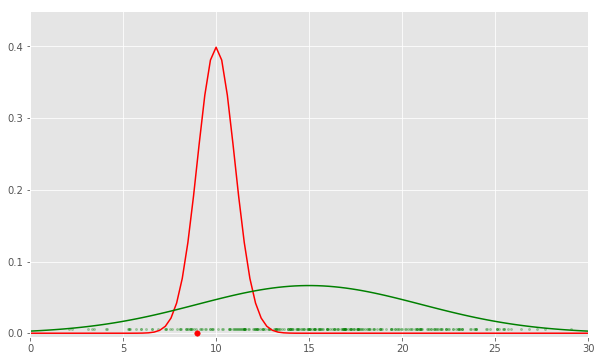

In [11]:
np.random.seed(108)
x__0 = stats.norm(10, 1).rvs(1)
x__1 = stats.norm(15, 6).rvs(300)
pdf__0 = stats.norm(10, 1).pdf
pdf__1 = stats.norm(15, 6).pdf

plt.figure(figsize=(10, 6))
lin_sp = np.linspace(start=0, stop=end, num=100)
plt.plot(lin_sp, pdf__0(lin_sp), color=color_0)
plt.plot(lin_sp, pdf__1(lin_sp), color=color_1)

plt.scatter(x__1, 0.006*np.ones(300), color='green', s=5, alpha=0.3)
plt.scatter(x__0, 0, color='red', s = 30)

plt.ylim(-0.005, 0.45)
plt.xlim(0, 30)
plt.show()

<p><a name="models"></a></p>
## Discriminant Analysis: Modeling

To build a Bayes classifier, the only thing we miss is the probability distribution of each class

$$
p(X=x \ | \ Y=k)
$$

Since this is a continuous distribution, the **Gaussian** distribution is widely used to model it. Different assumptions on Gaussian distribution result in different kind of classifiers. The following three are most common:

- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- Gaussian Naive Bayes (This is the same as QDA in a one dimensional case)

<p><a name="oneD"></a></p>
### The One Dimensional Case

When we have only one feature, we use one dimensional Gaussian distribution with a pdf 

$$
N(\mu, \sigma)(x) = \frac{1}{\sqrt{2\pi}\sigma}exp\big[{-\frac{1}{2}\big(\frac{x-\mu}{\sigma}\big)^2}\big]
$$

- Notice that it is sufficient to specify the **mean** and the **standard deviation** to specify a Gaussian distribution. 

In general we allow **different means** among different classes, but we assume identical standard deviation among different LDA classes:

**LDA**

For LDA, we assume that the standard deviation is the same for each class. In one dimensional case, this means that the distribution for each class $k \text{ is}$
$$
p(X=x \ | \ Y=k) = \frac{1}{\sqrt{2\pi}\sigma}exp\big[{-\frac{1}{2}\big(\frac{x-\mu_k}{\sigma}\big)^2}\big]
$$

With visualization, this means that the **width** of the distribution for each class remains the same.

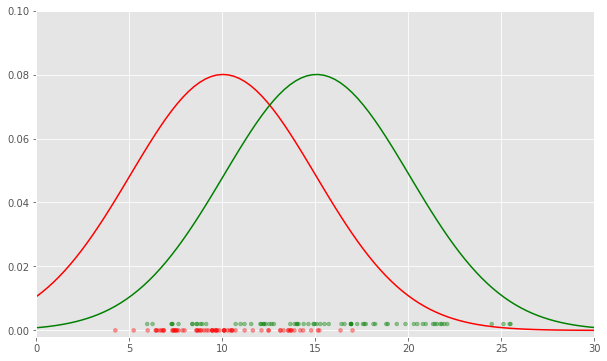

In [12]:
mu_0 = np.mean(x_0)
mu_1 = np.mean(x_1)
std = np.std( np.concatenate([x_0, x_1]) )

plt.figure(figsize=(10, 6))
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.002]*len_1, **scatter_kwargs)

point = np.linspace(start=0, stop=30, num=100)
plt.plot(point, stats.norm(mu_0, std).pdf(point), color='red')
plt.plot(point, stats.norm(mu_1, std).pdf(point), color='green')


plt.xlim(0,30)
plt.ylim(-0.002, 0.1)
plt.show()

**Question** 

- Now we know that with LDA the probability distribution for each class $k \text{ is}$
$$
p(X=x \ | \ Y=k) = \frac{1}{\sqrt{2\pi}\sigma}exp\big[{-\frac{1}{2}\big(\frac{x-\mu_k}{\sigma}\big)^2}\big]
$$
How do we decide $\mu_k \text{ and the class label independent } \sigma \text{ ?}$

**Answer**

$$
\begin{align}
\hat{\mu}_k &= \frac{1}{n_k}\sum_{i;y_i=k}x_i
\\
\hat{\sigma}^2 &= \frac{1}{n-K}\sum_{k=1}^{K}\sum_{i;y_i=k}(x_i-\hat{\mu}_k)^2
\\
&=\sum_{k=1}^{K}\frac{n_k-1}{n-K}\cdot\hat{\sigma}_k^2
\end{align}
$$

where
  - $\hat{\mu}_k$ is the sample mean of class $k$
  - $K$ is the total number of classes
  - $\hat{\sigma}_k^2=\frac{1}{n_k-1}\sum_{i;y_i=k}(x_i-\hat{\mu}_k)^2$ is the sample variance of class $k$
  - for $c_k = \frac{n_k-1}{n-K}$, we have $\sum_{k=1}^K c_k = \sum_{k=1}^K \frac{n_k-1}{n-K} = 1$
  - So the formula on $\hat{\sigma}$ is the weighted average of the various $\hat{\sigma}_k$

**QDA**

For QDA, the standard deviations are allowed to vary among the classes. In one dimensional case, this means the **width** of the distribution for each class can be different. Therefore:

$$
p(X=x \ | \ Y=k) = \frac{1}{\sqrt{2\pi}\sigma_k}exp\big[{-\frac{1}{2}\big(\frac{x-\mu_k}{\sigma_k}\big)^2}\big]
$$

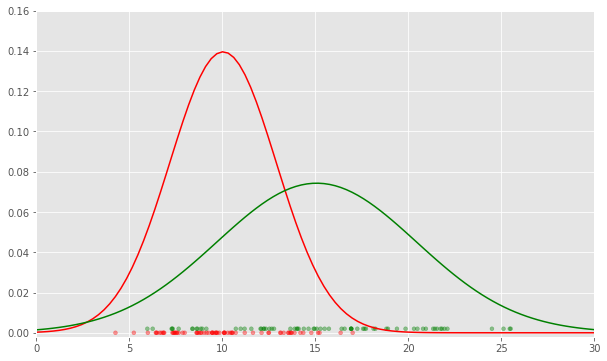

In [13]:
mu_0 = np.mean(x_0)
mu_1 = np.mean(x_1)
std_0 = np.std(x_0)
std_1 = np.std(x_1)

plt.figure(figsize=(10, 6))
plt.scatter(np.concatenate([x_0, x_1]), [0]*len_0 + [0.002]*len_1, **scatter_kwargs)

point = np.linspace(0, 30, 100)
plt.plot(point, stats.norm(mu_0, std_0).pdf(point), color='red')
plt.plot(point, stats.norm(mu_1, std_1).pdf(point), color='green')


plt.xlim(0,30)
plt.ylim(-0.002, 0.16)
plt.show()

**Question** 

- Now we know that with QDA the distribution for each class $k \text{ is}$
$$
p(X=x \ | \ Y=k) = \frac{1}{\sqrt{2\pi}\sigma_k}exp\big[{-\frac{1}{2}\big(\frac{x-\mu_k}{\sigma_k}\big)^2}\big]
$$
How do we estimate $\hat{\mu}_k$ and $\hat{\sigma}_k$?

<p><a name="highD"></a></p>
### Higher Dimensional Cases

We start with the discussion on higher dimensional Gaussian distribution. This is essentially the only difference in higher dimensional discriminant analysis.

<p><a name="highG"></a></p>
#### Higher Dimensional Gaussian Distribution

We still need only "two" parameters to specify higher dimensional Gaussian distribution: the **mean** and the **covariance**. However, for a p dimensional case (with p features),
- the mean is a p-dimensional vector
- the covariance is a $p \times p$ symmetric matrix

The probability density function becomes:
$$
N(\mu, \Sigma)(x) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}exp\big[{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}\big]
$$


**Mean**

The mean still decides where the "bell" is centered at.

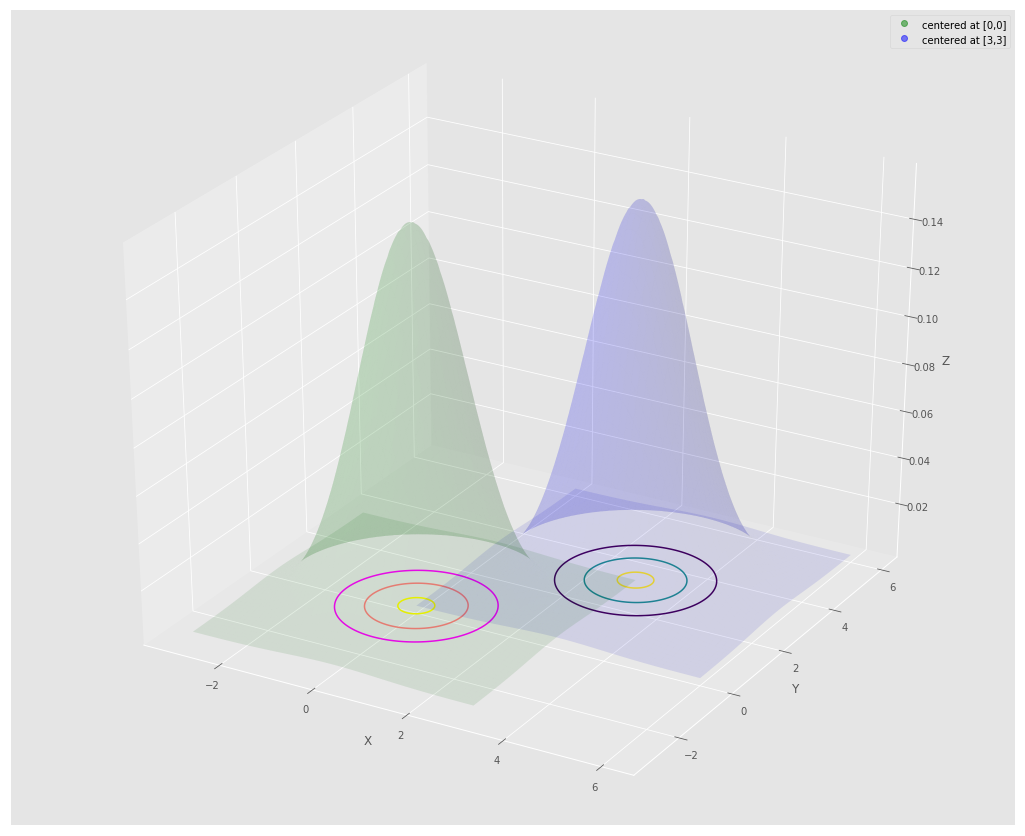

In [14]:
import matplotlib as mpl
from matplotlib import cm

mu_1 = np.array([0,0])
mu_2 = np.array([3,3])
sigma = np.matrix([[1, 0], [0, 1]])

fig = plt.figure(figsize=(18, 15))
ax = fig.gca(projection='3d')
multivariate_normal_plot(mu_1, sigma, n=5, step=0.05, color='green', ax=ax, alpha=0.1, cmap=cm.spring)
multivariate_normal_plot(mu_2, sigma, n=5, step=0.05, color='blue', ax=ax, alpha=0.1, cmap=cm.viridis)

# Legend
legend_kwargs = dict(linestyle='none', alpha=0.5, marker='o')
fake2Dline1 = mpl.lines.Line2D([0], [0], c='green', **legend_kwargs)
fake2Dline2 = mpl.lines.Line2D([0], [0], c='blue', **legend_kwargs)
ax.legend([fake2Dline1, fake2Dline2], ['centered at [0,0]', 'centered at [3,3]'], numpoints=1)

plt.show()

**Covariance Matrix**

The covariance matrix is a $p \times p \text{ matrix.}$ The covariance matrix, one of whose special cases is the square of standard deviation in one dimensional space, decides the **shape** of the "bell". However, the shape means more than just the width in a higher dimensional space.

**Width**

Let's compare two Gaussian distributions with different covariance matrices in a two dimensional space.

$
\Sigma_1 = 
\begin{bmatrix}
1 & 0 
\\[0.3em]
0 & 1
\end{bmatrix}
\text{ and } \ 
\Sigma_2 = 
\begin{bmatrix}
2 & 0 
\\[0.3em]
0 & 2
\end{bmatrix}
$

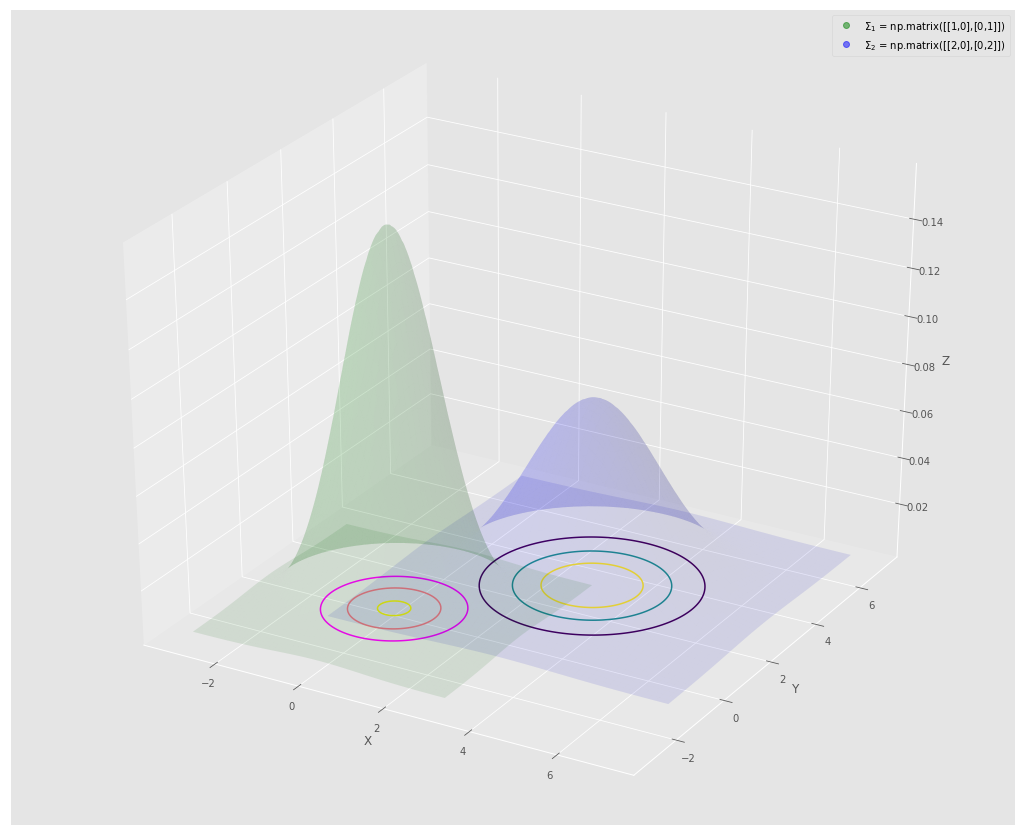

In [15]:
mu_1 = np.array([0,0])
mu_2 = np.array([3,3])
sigma_1 = np.matrix([[1, 0], [0, 1]])
sigma_2 = np.matrix([[2, 0], [0, 2]])

fig = plt.figure(figsize=(18, 15))
ax = fig.gca(projection='3d')
multivariate_normal_plot(mu_1, sigma_1, n=5, step=0.05, color='green', ax=ax, alpha=0.1, cmap=cm.spring)
multivariate_normal_plot(mu_2, sigma_2, n=5, step=0.02, width= 2, color='blue', ax=ax, alpha=0.1, cmap=cm.viridis)

# Legend
legend_kwargs = dict(linestyle='none', alpha=0.5, marker='o')
fake2Dline1 = mpl.lines.Line2D([0], [0], c='green', **legend_kwargs)
fake2Dline2 = mpl.lines.Line2D([0], [0], c='blue', **legend_kwargs)
label = ['$\Sigma_1$ = np.matrix([[1,0],[0,1]])', '$\Sigma_2$ = np.matrix([[2,0],[0,2]])']
ax.legend([fake2Dline1, fake2Dline2], label, numpoints=1)

plt.show()

**Correlation**

Each off-diagonal entry in the covariance matrix is proportional to the correlation between a pair of features. Let's compare the two cases below:

$
\Sigma_1 = 
\begin{bmatrix}
1 & 0 
\\[0.3em]
0 & 1
\end{bmatrix}
\text{ and } \ 
\Sigma_2 = 
\begin{bmatrix}
1 & 0.5 
\\[0.3em]
0.5 & 1
\end{bmatrix}
$

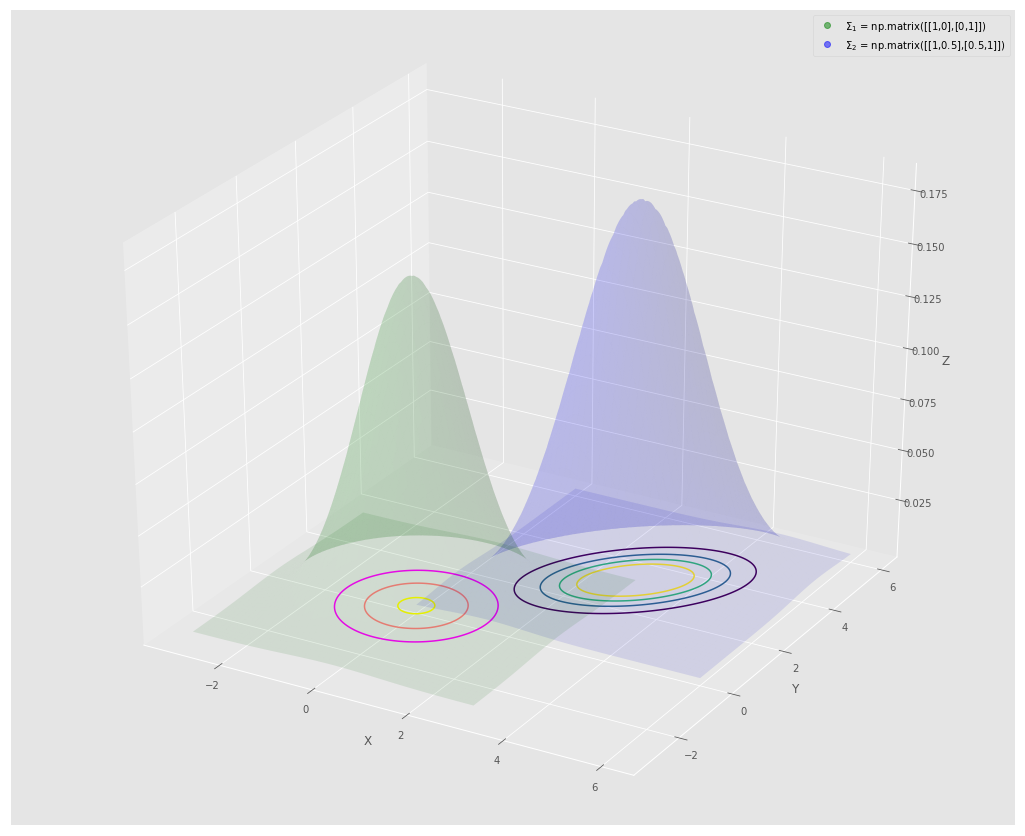

In [16]:
mu_1 = np.array([0,0])
mu_2 = np.array([3,3])
sigma_1 = np.matrix([[1, 0], [0, 1]])
sigma_2 = np.matrix([[1, 0.5], [0.5, 1]])

fig = plt.figure(figsize=(18, 15))
ax = fig.gca(projection='3d')
multivariate_normal_plot(mu_1, sigma_1, n=5, step=0.05, color='green', ax=ax, alpha=0.1, cmap=cm.spring)
multivariate_normal_plot(mu_2, sigma_2, n=5, step=0.03, width= 3, color='blue', ax=ax, alpha=0.1, cmap=cm.viridis)

# Legend
legend_kwargs = dict(linestyle='none', alpha=0.5, marker='o')
fake2Dline1 = mpl.lines.Line2D([0], [0], c='green', **legend_kwargs)
fake2Dline2 = mpl.lines.Line2D([0], [0], c='blue', **legend_kwargs)
label = ['$\Sigma_1$ = np.matrix([[1,0],[0,1]])', '$\Sigma_2$ = np.matrix([[1,0.5],[0.5,1]])']
ax.legend([fake2Dline1, fake2Dline2], label, numpoints=1)

plt.show()

In [17]:
from scipy.stats import multivariate_normal

covF = 1.8
gaussian2D = multivariate_normal(mean = [1,-2], cov=np.array([[2,covF],[covF,3]]))
X = gaussian2D.rvs(1000)

Text(0.5,1,'2D Scatterplot of Multi-Variate Gaussian Distribution')

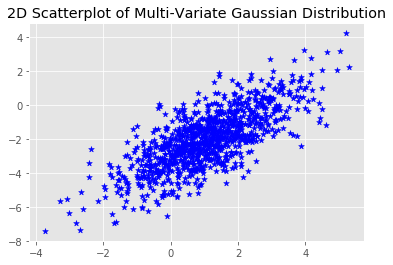

In [18]:
plt.scatter(X[:,0],X[:,1],c='b',marker='*')
plt.title('2D Scatterplot of Multi-Variate Gaussian Distribution')

#### Models in Higher Dimension

Recall what we have learned so far:

- The purpose is to classify based on numerical features, so we want to compute the probability of being in class $k \text{ under the condition that } X=x: \ P(Y=k \ | \ X=x)$

- By Bayes theorem we can re-express the conditional probability as below:
$$
P(Y=k \ | \ X=x) = \frac{p(X=x \ | \ Y=k) P(Y=k)}{\sum_{l}p(X=x \ | \ Y=l) P(Y=l)}
$$
so we only need to decide:
    - prior probability
    - the probability distribution of the feature in each class
    
- While estimating the **prior** is easy; estimating the distribution in each class is often hard

**The Assumptions on the Discriminatic Models in  Higher Dimension**

To estimate the distribution in each class, we need to make some additional assumptions. The ones below are shared by **LDA**, **QDA** and **GNB**:

- The distribution in each class is Gaussian (i.e. normal).
- Each Gaussian distribution centers at a possibly different position. (How do we find the centers?)

It is the different assumptions on the **covariant matrix** which differentiate these three models:

- LDA assumes every class has the **same covariance shape**; LDA allows **correlation** (off-diagonal entries).
- QDA allow **different covariance shape** for each class; QDA allows **correlation** (off-diagonal entries).
- GNB allow **different covariance shape** for each class; GNB requires **uncorrelated** features (diagonal covariance).

To illustrate the differences, let's consider the two-dimensional sample below:

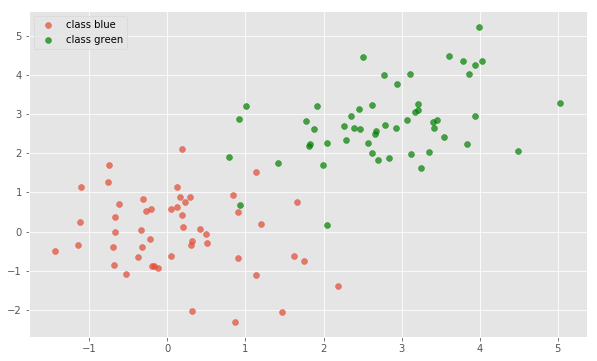

In [19]:
show_sample()
plt.show()

**QDA** 

We start with QDA. For this particular example, we need to compute the blue class conditional probability density:

$$
p(X=x \ | \ Y=b) = \frac{1}{(2\pi)|\Sigma_b|^{1/2}}exp\big[{-\frac{1}{2}(x-\mu_b)^T\Sigma_b^{-1}(x-\mu_b)}\big]
$$

and the green class conditional probability density,

$$
p(X=x \ | \ Y=g) = \frac{1}{(2\pi)|\Sigma_g|^{1/2}}exp\big[{-\frac{1}{2}(x-\mu_g)^T\Sigma_g^{-1}(x-\mu_g)}\big]
$$

- How do we estimate $\mu_b \text{, } \mu_g \text{, } \Sigma_b \text{ and } \Sigma_g \text{?}$

The training data we have is:
$$
\text{class blue } = 
\begin{bmatrix}
(x^b_1, y^b_1)\\
(x^b_2, y^b_2)\\
\vdots \\
(x^b_{50}, y^b_{50})\\
\end{bmatrix}
\quad \text{ and } \quad
\text{class green}=
\begin{bmatrix}
(x^g_1, y^g_1)\\
(x^g_2, y^g_2)\\
\vdots \\
(x^g_{53}, y^g_{53})\\
\end{bmatrix}
$$

**Questions**
- How do we compute $\hat{\mu}_b$ and $\hat{\mu}_g$?
- The covariance matrices are given by:
$$
\hat{\Sigma}_b =
\begin{bmatrix}
V_x^b & cov^b_{x, y} 
\\[0.3em]
cov^b_{y, x} & V^b_y
\end{bmatrix}
$$
What do the parameters mean? How do we compute these parameters?
- What about
$$
\hat{\Sigma}_g =
\begin{bmatrix}
V_x^g & cov^g_{x, y} 
\\[0.3em]
cov^g_{y, x} & V^g_y
\end{bmatrix}
$$

**LDA**

We need to compute, for each $k:$ 
$$
p(X=x \ | \ Y=k) = \frac{1}{(2\pi)|\Sigma|^{1/2}}exp\big[{-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)}\big]
$$

**Estimation**
- We compute $\hat{\mu}_b \text{ and } \hat{\mu}_g$ in the same way as before
- We have

$$
\quad\\
\hat{\Sigma} 
=\sum_{k\in \{b, g\}}\frac{n_k-1}{n-K}\cdot\hat{\Sigma}_k
$$

**GNB**

While the mean can be estimated in the same way, we need to estimate the covariance matrix for each $k:$ 
$$
\quad \\
p(X=x \ | \ Y=k) = \frac{1}{(2\pi)|\Sigma_k|^{1/2}}exp\big[{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}\big]
$$

- We still have
$$
\Sigma_b =
\begin{bmatrix}
V_x^b & cov^b_{x, y} 
\\[0.3em]
cov^b_{y, x} & V^b_y
\end{bmatrix}
$$
and
$$
\Sigma_g =
\begin{bmatrix}
V_x^g & cov^g_{x, y} 
\\[0.3em]
cov^g_{y, x} & V^g_y
\end{bmatrix}
$$

**Questions**

- What's the difference (simplification) from QDA?

**Answer**

- GNB assumes
$$
\Sigma_b =
\begin{bmatrix}
V_x^b & 0 
\\[0.3em]
0 & V^b_y
\end{bmatrix}
$$
and
$$
\Sigma_g =
\begin{bmatrix}
V_x^g & 0 
\\[0.3em]
0 & V^g_y
\end{bmatrix}
$$

Recall that GNB stands for **Gaussian Naive Bayes** classifier. The name indicates a Bayes classifier with Gaussian distribution. The assumption of Gaussian distribution, together with **mutually independent** features, implies that the features are uncorrelated. This is what the adjective **Naive** stands for.

<p><a name="discriminant-sklearn"></a></p>
## Discriminant Analysis in  Scikit-Learn

**Define some helper functions:**

We demonstrate **LDA** in `sklearn` with the tumor data.

In [20]:
#### Load the data if you haven't done so

path_to_file = "./data/tumor.csv"
data = pd.read_csv(path_to_file)
x_tm = data[["Size"]]
y_tm = data["Malignant"]

- Build the LDA model on the tumor data

In [21]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(x_tm, y_tm)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

- The score (accuracy) of your model


In [22]:
LDA.score(x_tm, y_tm)

0.9166666666666666

## Major Attributes of the LDA Model Object
- fit: training the model
- score: accuracy
- predict: output the prediction
- predict_proba: output the class probabilities
- get_params
- set_params
- priors_: 
- means_: class means of the samples
- store_covariance: bool, whether to store covariance matrix
- covariance_: available only when store_covariance is True
- decision_function
- explained_variance_ratio

- Predict with the LDA model:

In [23]:
LDA.predict(x_tm)

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [24]:
LDA.predict_proba(x_tm)

array([[2.23324866e-01, 7.76675134e-01],
       [9.28976428e-01, 7.10235723e-02],
       [9.71558053e-01, 2.84419470e-02],
       [9.99884338e-01, 1.15662406e-04],
       [9.89915656e-01, 1.00843444e-02],
       [9.91878439e-01, 8.12156089e-03],
       [1.17407353e-02, 9.88259265e-01],
       [5.23386704e-02, 9.47661330e-01],
       [1.05317448e-02, 9.89468255e-01],
       [3.49201664e-02, 9.65079834e-01],
       [2.77474581e-01, 7.22525419e-01],
       [7.73307442e-04, 9.99226693e-01]])

Text(0.5,1,'class estimated probabilities')

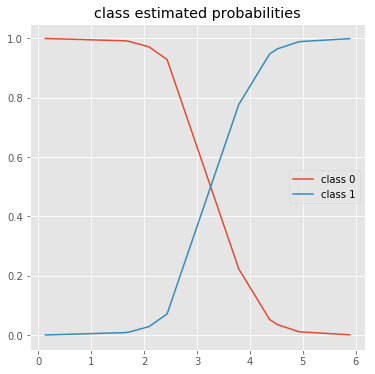

In [25]:
plt.rcParams['figure.figsize'] = (6,6)
x_tm = x_tm.sort_values('Size')
proba = LDA.predict_proba(x_tm)
plt.plot(x_tm, proba[:,0], label='class 0')
plt.plot(x_tm, proba[:,1], label='class 1')
plt.legend(loc=7)
plt.title('class estimated probabilities')

array([[2.82332195]])

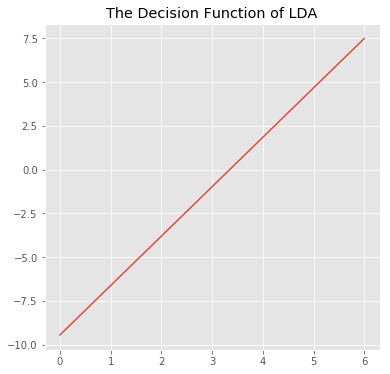

In [26]:
X = np.linspace(0,6,100)
Y = LDA.decision_function(X.reshape((-1,1)))
plt.plot(X,Y)
plt.title('The Decision Function of LDA')
LDA.coef_  # This stores the slope of the line

- Plot the decision boundary

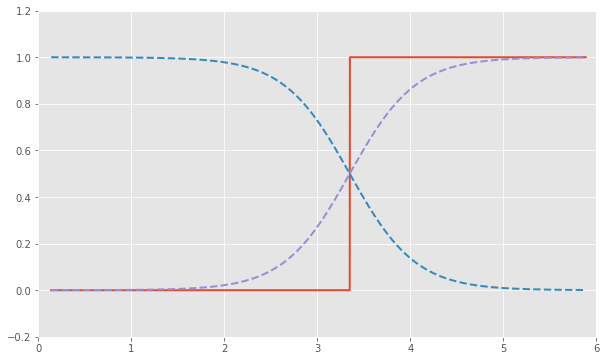

In [27]:
## Plot data points
from PlottingFunction import lda_1Dplot, plotModel, data_1Dplot
plt.figure(figsize=(10, 6))
#data_1Dplot(x_tm, y_tm, \
#             xlabel="Size", ylabel="Malignant?", \
#             labels=["No", "Yes"], \
#             title="Tumor Size and Malignancy")
## Plot LDA prediction probabilities
lda_1Dplot(x_tm, LDA)
plt.axis([0, 6, -.2, 1.2])
plt.show()

<p><a name="ex1"></a></p>
#### Example 1

We will work on the `iris` data

In [28]:
#### Load the data if you haven't done so

from sklearn import datasets
iris = datasets.load_iris()
pair = (2, 3)

xlabel = iris.feature_names[pair[0]]
ylabel = iris.feature_names[pair[1]]

iris_x = iris.data[:, pair]
iris_y = iris.target

- Fit a LDA model with all features of iris dataset, what's your overall accuracy?

In [29]:
#### Your code here, still call your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
LDA.fit(iris.data, iris.target)
print('Accuracy %.2f' %(LDA.score(iris.data, iris.target)))
print('\npriors\n %s' %(LDA.priors_))
print('\nClass means\n %s' %(LDA.means_))
print('\nCovariance matrix \n%s' %(LDA.covariance_))

Accuracy 0.98

priors
 [0.33333333 0.33333333 0.33333333]

Class means
 [[5.006 3.418 1.464 0.244]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]

Covariance matrix 
[[0.259708   0.09122    0.16409333 0.037704  ]
 [0.09122    0.11356667 0.05413333 0.03275467]
 [0.16409333 0.05413333 0.18146667 0.04169067]
 [0.037704   0.03275467 0.04169067 0.04117067]]


## Finding the Predicted Class Labels Through Maximal Decision Values
- For $3$-class classification problem, there are three **decision functions**, one for each class
- The decision function associated with class 0 discerns between class 0 and non-class 0 samples
- Later it is generalized to **ovr** ensembling technique for other binary classifiers
- For **LDA**, the **decision functions** are always linear
- For a given sample, the three **decision functions** produce three **decision values**. The output class label is the one
which has the highest **decision value**

In [30]:
decision_values = LDA.decision_function(iris.data)
np.argmax(decision_values, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Finding the Predicted Class Labels Through Maximal Probabilities
- For $3$-class classification problem, there are three **class probabilities**, one for each class
- **LDA** produces the **class probabilities** through **Bayes Theorem**
- The output class label is the one which has the highest probability
- This is a special case of **Bayesian Decision Theory**

In [31]:
proba = LDA.predict_proba(iris.data)
np.argmax(proba, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [32]:
iris.data.shape

(150, 4)

In [33]:
LDA._max_components

2

- ${\bf explained\_variance\_ratio\_}$
- The attribute **_max_components** is by default equal to num_classes - 1, i.e. 2, in our case
- **LDA** tries to capture the best **_max_components** dimensional linear subspace to project the data to where the
centers (i.e. means) are located

In [34]:
## The explained variance from the top two dimension
LDA.explained_variance_ratio_

array([0.99147248, 0.00852752])

## Visualization of LDA Decision Boundaries

- We now select two features at a time and visualize the LDA decision boundaries. Check the output plots.

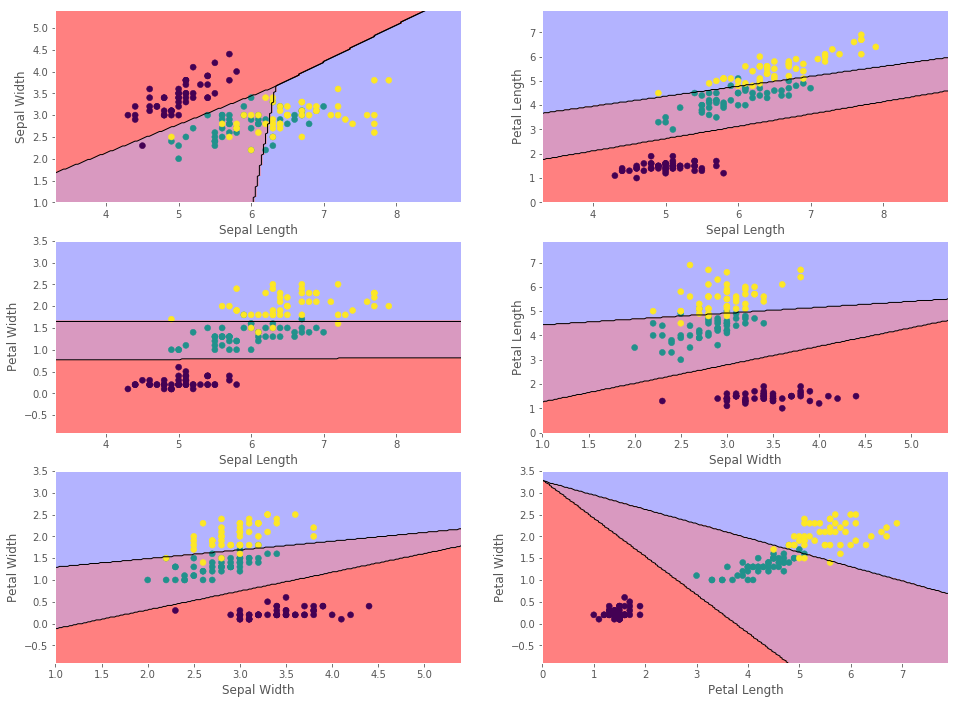

In [35]:
plt.rcParams['figure.figsize'] = 16, 12
labels = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width" ]

def pairPlot(model, i, j):
    model.fit(iris.data[:, [i, j]], iris.target)
    plotModel(model, iris.data[:, i], iris.data[:, j], iris.target)
    plt.xlabel(labels[i])
    plt.ylabel(labels[j])
    
plt.subplot(321)
pairPlot(LDA, 0, 1)

plt.subplot(322)
pairPlot(LDA, 0, 2)

plt.subplot(323)
pairPlot(LDA, 0, 3)

plt.subplot(324)
pairPlot(LDA, 1, 2)

plt.subplot(325)
pairPlot(LDA, 1, 3)

plt.subplot(326)
pairPlot(LDA, 2, 3)

plt.show()

<p><a name="ex2"></a></p>
#### Example 2

- Create a QDA model and train it with the iris data.

In [36]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
QDA.fit(iris.data, iris.target)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=True, store_covariances=None, tol=0.0001)

- What is the accuracy of your model?

In [37]:
QDA.score(iris.data, iris.target)

0.98

## Finding the Predicted Class Labels Through Maximal Decision Values
- The three decision functions for a 3-class **QDA** are all quadratic
- Similar to **LDA**, the predicted class label is associated to the highest **decision value** 

In [38]:
np.argmax(QDA.decision_function(iris.data), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Finding the Predicted Class Label Through Maximalizing the Class Probabilities

In [39]:
np.argmax(QDA.predict_proba(iris.data), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Mean Values of All Three Iris Classes

In [40]:
QDA.means_[0]

array([5.006, 3.418, 1.464, 0.244])

In [41]:
QDA.means_[1]

array([5.936, 2.77 , 4.26 , 1.326])

In [42]:
QDA.means_[2]

array([6.588, 2.974, 5.552, 2.026])

## Covariance Matrices of All Three Iris Classes

In [43]:
QDA.covariance_[0]

array([[0.12424898, 0.10029796, 0.01613878, 0.01054694],
       [0.10029796, 0.14517959, 0.01168163, 0.01143673],
       [0.01613878, 0.01168163, 0.03010612, 0.00569796],
       [0.01054694, 0.01143673, 0.00569796, 0.01149388]])

In [44]:
QDA.covariance_[1]

array([[0.26643265, 0.08518367, 0.18289796, 0.05577959],
       [0.08518367, 0.09846939, 0.08265306, 0.04120408],
       [0.18289796, 0.08265306, 0.22081633, 0.07310204],
       [0.05577959, 0.04120408, 0.07310204, 0.03910612]])

In [45]:
QDA.covariance_[2]

array([[0.40434286, 0.09376327, 0.3032898 , 0.04909388],
       [0.09376327, 0.10400408, 0.07137959, 0.04762857],
       [0.3032898 , 0.07137959, 0.30458776, 0.04882449],
       [0.04909388, 0.04762857, 0.04882449, 0.07543265]])

- Below we visualize the decision boundary for each pair of features.

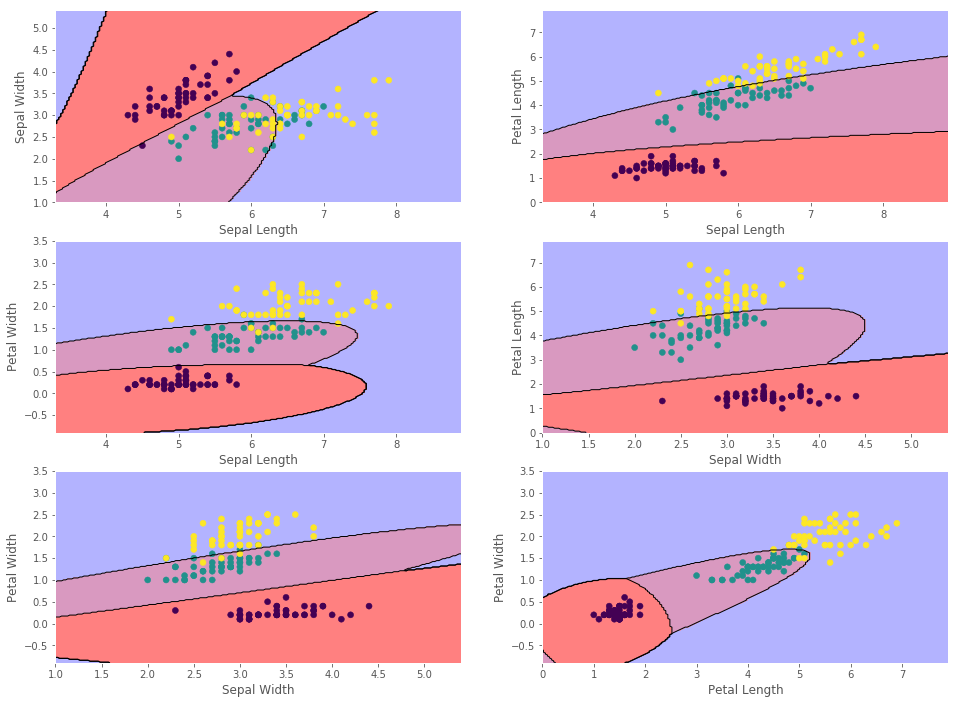

In [46]:
plt.rcParams['figure.figsize'] = 16, 12
plt.subplot(321)
pairPlot(QDA, 0, 1)

plt.subplot(322)
pairPlot(QDA, 0, 2)

plt.subplot(323)
pairPlot(QDA, 0, 3)

plt.subplot(324)
pairPlot(QDA, 1, 2)

plt.subplot(325)
pairPlot(QDA, 1, 3)

plt.subplot(326)
pairPlot(QDA, 2, 3)

plt.show()

<p><a name="nb"></a></p>
## Naive Bayes

Recall that the Bayes theorem asserts that, given $X=x$, that the probability of the output being in class $k$ can be estimated by:

$$
Pr(Y=k|X=x) = \frac{f_k(x)\pi_k}{\sum_{l}f_l(x)\pi_l},
$$

$\pi_l = P(Y=k)$, and $f_k(x) = P(x|Y=k)$

LDA and QDA use multivariate Gaussian densities (but with different assumptions on their covariance matrices). These do not work well when the number of features is large.

Naive Bayes models assume that the different features are conditionally independent in each class so can work with dataset of large number of features.

The *naive Bayes classifier* is based on Bayes theorem with the additional independence assumptions between predictors.

The assumption of conditional independence requires the class $k$ probability density to factorize:

$$
f_k(x) = \prod_{j=1}^{p}f_{jk}(x)
$$
where $f_{jk}(x)$ is the probability density for the *j*th feature $X_j$ in class $k$.

We will introduce three kinds of Naive Bayesian models:
- *Gaussian Naive Bayes*
- *Multinomial Naive Bayes*
- *Bernoulli Naive Bayes*

<p><a name="gnb"></a></p>
### Gaussian Naive Bayes (GNB)
Gaussian Naive Bayes assumes each feature follows a gaussian distribution ($\Sigma_k$ is diagonal):

$$
f_{jk}(x) = \frac{1}{\sqrt{2\pi}\sigma_{jk}}exp\big[-\frac{(x_j-\mu_{jk})^2}{2\sigma_{jk}^2}\big]
$$
where:
- $\mu_{jk}$: the mean of the *j*th feature $x_j$ in class $k$
- $\sigma_{ij}$: the variance of the *j*th feature $x_j$ in class $k$

Since we assume gaussian densities, it's best used for continuous features.

`GaussianNB` implements the Gaussian Naive Bayes algorithm for classification.

<p><a name="gnb-sklearn"></a></p>
### Gaussian Naive Bayes in Scikit-Learn

**Exercise**

We will work on the iris data. Fit a Gaussian Naive Bayes model and print out its accuracy:

In [47]:
from sklearn import naive_bayes
gnb = naive_bayes.GaussianNB()

#### Your code here
gnb.fit(iris.data, iris.target)
print(gnb.score(iris.data, iris.target))

0.96


- Use `predict()` and `predict_proba()` methods to predict the new data point `x_new = [2.8, 5.6, 3.2, 6.7]`.

In [48]:
#### Your code here
x_new = np.array([2.8, 5.6, 3.2, 6.7]).reshape(1, -1)
print("classification: {}".format(gnb.predict(x_new)))
print("probability: {}".format(gnb.predict_proba(x_new)))

classification: [2]
probability: [[0.00000000e+000 1.26443199e-100 1.00000000e+000]]


- Below we visualize the decision boundary for each pair of features.

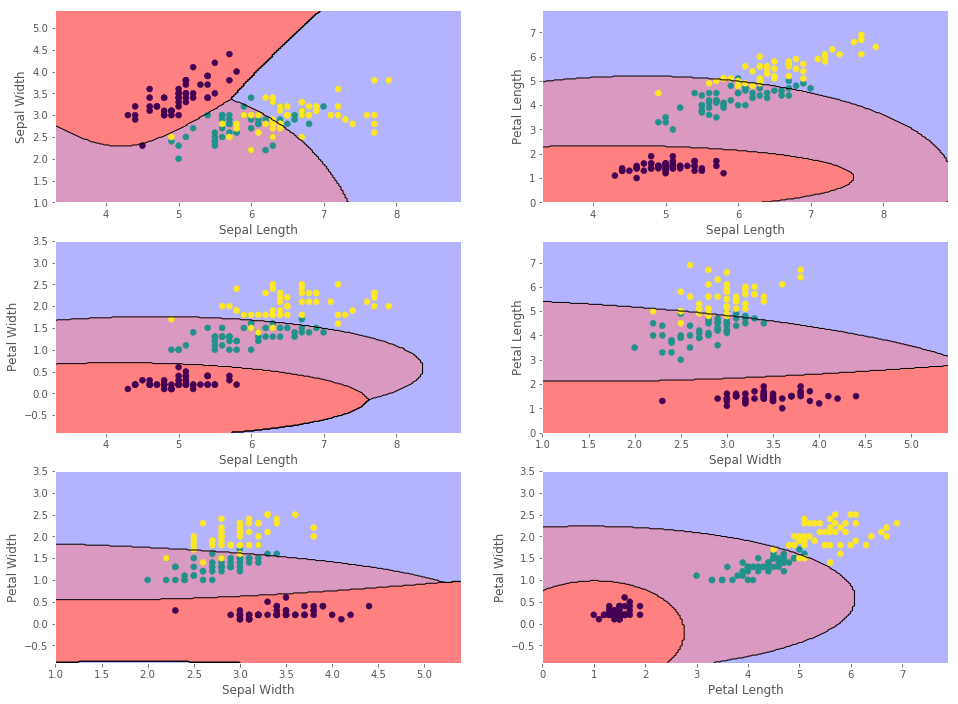

In [49]:
plt.rcParams['figure.figsize'] = 16, 12
plt.subplot(321)
pairPlot(gnb, 0, 1)

plt.subplot(322)
pairPlot(gnb, 0, 2)

plt.subplot(323)
pairPlot(gnb, 0, 3)

plt.subplot(324)
pairPlot(gnb, 1, 2)

plt.subplot(325)
pairPlot(gnb, 1, 3)

plt.subplot(326)
pairPlot(gnb, 2, 3)

plt.show()

<p><a name="compare"></a></p>

### Bernoulli, Binomial and Multinomial Distributions
- Bernoulli distribution models an unfair two-sided coin-flip $1$ time
- Binomial distribution models independent (un)fair two-sided coin-flips $N$ times
- Multinomial distribution models independent $k$-sided (un)fair coin-flips $N$ times

### Summary

- Given a binary random variable with values in $\{'H', 'T'\}$, the Bernoulli distribution models the probabilities of taking 'head', $p$, and taking 'tail', $1-p$.
- Suppose that we flip the (unfair) coin $N$ times independently, we are interested in the frequency counts of the heads and the tails. The Binomial distribution models the number of heads in terms of $N$ and $p$.
- Suppose that we flip an $M$-sided coin $N$ times independently (this resembles $N$ independent samples of a $M$-level categorical variable), we are interested in knowing the frequency count of the dice taking any particular side. The Multinomial distribution models the counts of all $M$ faces, given the probabilities of drawing the $m$-th side, $p_m, 1\leq k \leq M$, $\sum_{m\leq M}p_m=1$.
- When $M=2$, the multinomial distribution is reduced back to a binomial distribution
- The binomial distribution models the repeatedly independent random draws of a *Bernoulli distribution*
- The multinomial distribution models the repeatedly independent random draws of a *Categorical distribution*

<p><a name="mnb"></a></p>
### Multinomial Naive Bayes
For categorical data, the Gaussian (normality) assumption is not realistic.
If the columns of the raw data are categorical within the same finite range, then we can use the distinct discrete values as the features and compute the frequency count of the appearance of each feature. With this understood, then we can parameterize the probability distribution by a vector $\theta_{k} = ({\theta_{k1}}, {\theta_{k2}}, ..., {\theta_{kF}})$ for each class $k$,

where:
- $F$: the number of features. 
- ${\theta_{kf}}$: the probability $P(x_f|k)$ of the $f-th$ feature occurs in the samples labeled by class $k$.
- Fixing a class label $k$, *MultinomialNB* implements the naive Bayes algorithm for multinomially distributed data, and is widely used in *text classification (text categorization)*, where the term *naive* means independence of the appearance of distinct text tokens.
- In the context of *text classification*, the positions within the documents are the raw features and the different tokens (normalized words) are the discrete categories.
- In such context, we model the word/token counts in the multinomial Naive Bayes.
- Then the $\theta_{kf}, 1\le f \le F$ captures the relative frequency count of the text token in the class $k$ documents.

**Multinomial Naive Bayes Example**

- In our spam email data, for simplicity we choose three words (features) to build our model: "sale", "money", "work", denoted by $x_1, x_2, x_3$, respectively.

- Among all the spams, the word "sale" appears $48$ times, "money" appears $50$ times,  and "work" appears $2$ times. $100$ in total.
Then we have:
$$\theta_1 = \{0.48, 0.50, 0.02 \}$$

- In the non-spams, the frequency count of $x_1, x_2, x_3$ are $5$, $10$, $85$.
Then we have:
$$\theta_0 = \{0.05, 0.10, 0.85 \}$$

- Each document (spam or non-spam) can be viewed as repeated draws from a bag of 'sale', 'money' and 'work', specified by $\theta_0$ or $\theta_1$. 

<p><a name="mnb-sklearn"></a></p>
### Multinormial Naive Bayes in Scikit-Learn

The file "spam_train.csv" in the "data" folder contains 2300 emails and 58 variables. The last variable "spam" is binary with two levels: "email", "spam". If you want to know more about the data set, please read the file "spam.txt".

We will try to build a **multinomial NB** classifier based on this data set, using the first 57 features to predict the "spam" variable.

In [50]:
train = pd.read_csv('./data/spam_train.csv')
## separate the predictors and response in the training data set
x = np.array(train.iloc[:, 0:57])
y = np.ravel(train.iloc[:, 57:58])
train.head()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0,0.32,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.0,0.234,0.0,0.058,0.0,0.0,1.068,3,47,email
1,0.00,0.0,0.71,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.342,0.0,0.0,1.000,1,31,email
2,0.00,0.0,0.00,0.0,0.00,0.17,0.0,0.0,0.0,0.0,...,0.0,0.055,0.0,0.000,0.0,0.0,1.685,7,204,email
3,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.0,0.0,1.800,5,9,email
4,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.471,0.0,0.000,0.0,0.0,1.424,8,47,email


In [51]:
train.max(axis=0)

A.1       4.54
A.2      14.28
A.3        5.1
A.4      40.13
A.5         10
A.6       3.57
A.7       7.27
A.8       4.62
A.9       3.33
A.10      5.26
A.11         2
A.12      9.67
A.13      5.55
A.14        10
A.15      4.41
A.16        20
A.17      4.81
A.18      9.09
A.19     18.75
A.20      6.25
A.21      8.69
A.22      17.1
A.23      4.76
A.24      9.75
A.25     20.83
A.26     16.66
A.27     33.33
A.28      9.09
A.29     14.28
A.30      4.76
A.31      12.5
A.32      4.76
A.33       7.4
A.34      4.76
A.35        20
A.36      4.76
A.37      5.05
A.38         4
A.39      7.14
A.40      4.76
A.41      7.14
A.42     14.28
A.43      3.03
A.44     16.66
A.45     21.42
A.46        10
A.47      0.88
A.48        10
A.49     4.367
A.50     2.941
A.51     2.777
A.52    32.478
A.53     3.305
A.54    19.829
A.55    337.25
A.56      1505
A.57      9163
spam      spam
dtype: object

- The data matrix is not the integer word counts. But the first $55$ columns are **fractional** word counts

In [52]:
y == 'spam'

array([False, False, False, ..., False, False,  True])

In [53]:
print("     spam:", np.sum(y == 'spam'))
print("None spam:", np.sum(y != 'spam'))

     spam: 911
None spam: 1389


- Create a multinomial naive Bayes model and train it with the data above. What is the accuracy of the model?

In [54]:
#### Your code here
mnb = naive_bayes.MultinomialNB()
mnb.fit(x, y)
print("The score of multinomial naive bayes is: %.4f" %mnb.score(x, y))

The score of multinomial naive bayes is: 0.8109


**Demonstration**

As naive bayes is widely used for spam filtering, we expect a result much better than 81%! 

A commonly used technique is to perform feature selection (trying **fewer** features)!

Previously, we have used 57 features, not all of them are correlated with the response variable. So this time we choose only the first 48 features and see what will happen.

In [55]:
x_48 = x[:, 0:48]
mnb.fit(x_48 , y)
print(mnb.score(x_48, y))

0.871304347826087


Since accuracy doesn't increase with the number of features, we add features incrementally by their order and inspect the variations of the accuracy.

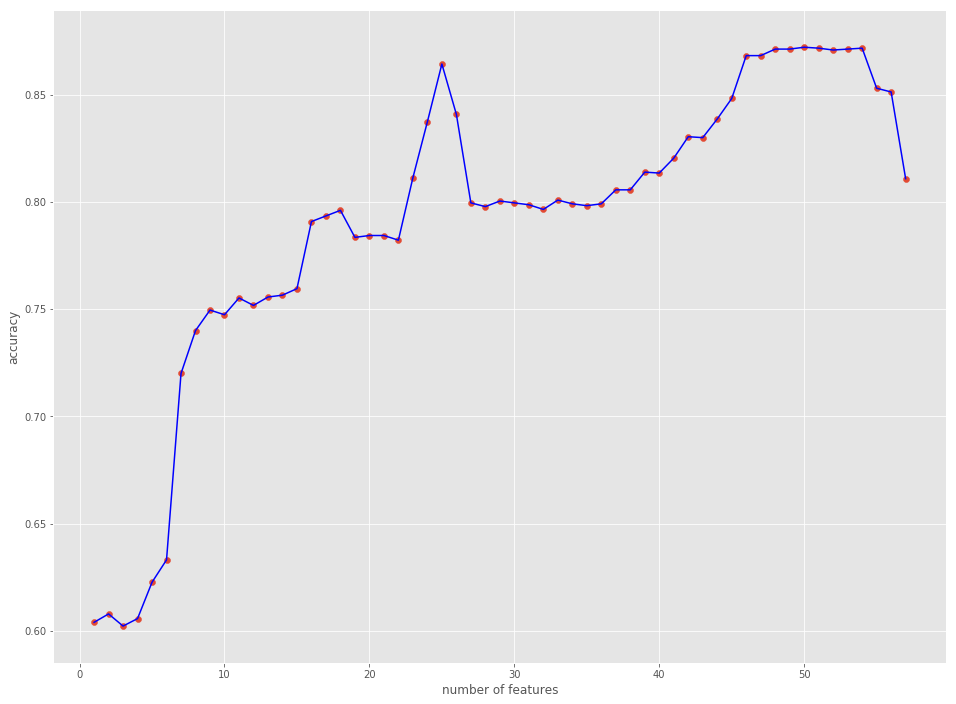

In [56]:
n = range(1, 58)
accuracy = []
for i in n:
    mnb.fit(x[:, 0:i] , y)
    accuracy.append(mnb.score(x[:, 0:i] , y))

plt.scatter(n, accuracy)
plt.plot(n, accuracy, c='b')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()

As the features increase, the training accuracy increases dramatically at first. It reaches the peak at $k$=47, then adding more features does not increase its accuracy, and the accuracy begins to decrease at about $k=54$.
It seems that including all features does not ensure a better result.

We will discuss feature selection and regularization in a separate session.

<p><a name="bnb"></a></p>
### Bernoulli Naive Bayes

- Bernoulli Naive Bayes is used for the data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (boolean) variable

- Consider the spam filter problem, in Bernoulli naive Bayes we do not care about the frequency any more. We are just interested at the appearance or non-appearance. 

- Given a feature $x_k$ representing a token/word, we focus on whether it appears in an email or not. What's the probability of its appearance?

`BernoulliNB` implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable

**Bernoulli Naive Bayes Example**

Suppose we have 80 non-spams in which the word "sale", denoted by $x_k$, appears in $10$ of them; we also have 20 spams in which $x_k$ appears among $16$ of them. We use $y=1$ to indicate a spam email. Then:
$$
\begin{align}
p(x_k = 1 | y = 1) &= \frac{16}{20} = \frac{4}{5},  \quad p(x_k = 0 | y = 1) = \frac{1}{5} \\
p(x_k = 1 | y = 0) &= \frac{10}{80} = \frac{1}{8},  \quad p(x_k = 0 | y = 0) = \frac{7}{8} 
\end{align}
$$

Given a new email which contains the word "sale", namely $x_k=1$. If we just use this one feature to predict:
$$
p(y=1 | x_k=1) = \frac{p(y=1)p(x_k=1|y=1)}{p(x_k=1)} = \frac{\frac{20}{100} \times \frac{4}{5}}{p(x_k=1)} = \frac{0.16}{p(x_k=1)}
\\
p(y=0 | x_k=1) = \frac{p(y=0)p(x_k=1|y=0)}{p(x_k=1)} = \frac{\frac{80}{100} \times \frac{1}{8}}{p(x_k=1)} = \frac{0.1}{p(x_k=1)}
$$

Since $p(y=1|x_k=1) > p(y=0|x_k=1)$, we will conclude that this email is a spam.

<p><a name="bnb-sklearn"></a></p>
### Bernoulli Naive Bayes in Scikit-Learn

- Train a BNB model with the data. Report the accuracy.

In [57]:
## create a instance 
bnb = naive_bayes.BernoulliNB()
## fit model
bnb.fit(iris.data, iris.target)
## print out the mean accuracy
print("The mean accuracy of Bernoulli Naive Bayes is: " + str(bnb.score(iris.data, iris.target)))

The mean accuracy of Bernoulli Naive Bayes is: 0.3333333333333333


**Demonstration** 

Note that Bernoulli naive Bayes performs poorly here (worse than the random guess). 
The algorithm converts continuous features to binary features using the default cut-off 0.0 (controlled by the default value of binarize = 0.0)
We may need to discretize the feature values into two distinct levels in a controlled manner. In order to do this, set the argument "binarize" to be $1.5$ manually, the algorithm will treat $1.5$ as a threshold and cut off the variables into binary data:
If we set binarize = None, the algorithm will treat the data as being pre-binarized already

In [58]:
bnb.set_params(binarize = 1.5)
## fit model again
bnb.fit(iris.data, iris.target)
## print out the mean accuracy
print("The mean accuracy of Bernoulli Naive Bayes is: " + str(bnb.score(iris.data, iris.target)))

The mean accuracy of Bernoulli Naive Bayes is: 0.86


Now the prediction is much better, the accuracy reaches up to 86% from 33.3%.

Next we may consider to search for a better threshold: Let's do a for loop and try to find it.

In [59]:
accuracy = []
line = np.linspace(start=0, stop=8, num=100)
for i in line:
    bnb.set_params(binarize = i)
    bnb.fit(iris.data, iris.target)
    accuracy.append(bnb.score(iris.data, iris.target))
    
accuracy = np.array(accuracy)
print("The highest accuracy is: " + str(accuracy.max()))
print("The corresponding threshold is: " + str(line[accuracy.argmax()]))

The highest accuracy is: 0.9466666666666667
The corresponding threshold is: 1.777777777777778


We see that when the threshold is around 1.778, the mean accuracy can reach up to 94.67%! So a better threshold is crucial. In practice, we may need to set a threshold for each input variable to make a better prediction.